# Parameter Exploration

In this notebook we will investigate the effect of the choice of quality function and resolution parameter on the detected communities.

To do that, we use the [_jazz musicians network_](http://konect.cc/networks/arenas-jazz/), which consists of 198 nodes, representing jazz musicians, and 2742 edges, representing collaborations between two musicians.

## Loading the dataset
As always, we begin by importing required components and seeding the random number generator for repeatable results:

In [1]:
import random
from timeit import default_timer as timer

import networkx as nx
import matplotlib.pyplot as plt

from community_detection.utils import Partition, argmax
from community_detection.leiden import leiden as leiden_o
from community_detection.louvain import louvain as louvain_o
from community_detection.quality_functions import CPM, Modularity

# The seed "0" is interesting, as we see a large difference in the maxima for the CPM quality function
SEED = 0

The Jazz network is provided by the `jazz.py` file in the `datasets` directory:

In [2]:
import datasets.jazz
G = datasets.jazz.get_graph()
print(f"Loaded {len(G.nodes)=} musicians and {len(G.edges)=} collaborations.")

Loaded len(G.nodes)=198 musicians and len(G.edges)=2742 collaborations.


In order to get a graph that is useful to us, we need to reseed the random number generator before doing any call to one of the community detection algorithms. Otherwise we can't compare partitions generated by the same algorithm for different parameters.

In [3]:
def leiden(*args, **kwargs):
    random.seed(SEED)
    start = timer()
    result = leiden_o(*args, **kwargs)
    runtime = timer() - start
    return result, runtime


def louvain(*args, **kwargs):
    random.seed(SEED)
    start = timer()
    result = louvain_o(*args, **kwargs)
    runtime = timer() - start
    return result, runtime

## Generating the parameters
We will now apply both the Louvain and Leiden algorithms to the jazz musician graph for varying values of the resolution parameter γ.
We're using the values 0.4 to 2.0 in steps of 0.02:

In [4]:
resolutions_mod = [0.40 + 0.02 * d for d in range(61)] # 0.40 ... 1.60
resolutions_cpm = [0.04 + 0.02 * d for d in range(48)] # 0.04 ... 0.98

We will now perform community detection using both, the louvain and leiden algorithms, and using both the Modularity and CPM quality functions, for the values of γ defined above:

In [5]:
# Run louvain and leiden algorithms for all resolutions with the Modularity quality function
coms_louvain_mod, times_louvain_mod = map(list, zip(*[louvain(G, Modularity(res)) for res in resolutions_mod]))
coms_leiden_mod,  times_leiden_mod  = map(list, zip(*[leiden (G, Modularity(res)) for res in resolutions_mod]))
# Now repeat this with CPM as the quality function
coms_louvain_cpm, times_louvain_cpm = map(list, zip(*[louvain(G, CPM(res)) for res in resolutions_cpm]))
coms_leiden_cpm,  times_leiden_cpm  = map(list, zip(*[leiden (G, CPM(res), θ=0.8) for res in resolutions_cpm]))

Having done this, we can calculate the modularity for γ=1 (the "standard" modularity) for all of the results.  
It is important that, although we used different quality functions (modularity and cpm, with different resolutions), we need to use one single common quality functions for comparing the quality of the results.

In [6]:
mod = Modularity(1.0)
mod_louvain_mod = [mod(part) for part in coms_louvain_mod]
mod_leiden_mod  = [mod(part) for part in coms_leiden_mod]
mod_louvain_cpm = [mod(part) for part in coms_louvain_cpm]
mod_leiden_cpm  = [mod(part) for part in coms_leiden_cpm]

Having calculated these modularities, we can now determine which value of the parameter $γ$ for the quality function used in the algorithms, by measuring the quality of the resulting communities using the modularity metric, with a parameter of $γ=1$ used for comparison of the results:

In [7]:
idx_louvain_mod = argmax(lambda x: x, mod_louvain_mod)[2]
idx_leiden_mod  = argmax(lambda x: x, mod_leiden_mod)[2]
idx_louvain_cpm = argmax(lambda x: x, mod_louvain_cpm)[2]
idx_leiden_cpm  = argmax(lambda x: x, mod_leiden_cpm)[2]

print(f"Best result for Louvain algorithm with Mod.: Modularity={mod_louvain_mod[idx_louvain_mod]:0.5f} " +
      f"with γ={resolutions_mod[idx_louvain_mod]:.3f}, yielding {len(coms_louvain_mod[idx_louvain_mod])} communities")
print(f"Best result for Leiden algorithm with Mod.:  Modularity={mod_leiden_mod[idx_leiden_mod]:0.5f} " +
      f"with γ={resolutions_mod[idx_leiden_mod]:.3f}, yielding {len(coms_leiden_mod[idx_leiden_mod])} communities")

print(f"Best result for Louvain algorithm with CPM:  Modularity={mod_louvain_cpm[idx_louvain_cpm]:0.5f} " +
      f"with γ={resolutions_cpm[idx_louvain_cpm]:.3f}, yielding {len(coms_louvain_cpm[idx_louvain_cpm])} communities")
print(f"Best result for Leiden algorithm with CPM:   Modularity={mod_leiden_cpm[idx_leiden_cpm]:0.5f} " +
      f"with γ={resolutions_cpm[idx_leiden_cpm]:.3f}, yielding {len(coms_leiden_cpm[idx_leiden_cpm])} communities")

Best result for Louvain algorithm with Mod.: Modularity=0.44403 with γ=0.540, yielding 3 communities
Best result for Leiden algorithm with Mod.:  Modularity=0.44403 with γ=0.760, yielding 3 communities
Best result for Louvain algorithm with CPM:  Modularity=0.42466 with γ=0.120, yielding 19 communities
Best result for Leiden algorithm with CPM:   Modularity=0.41782 with γ=0.160, yielding 19 communities


So with modularity, both algorithms arrived at partitions with the same quality and the same number of communities.
The Leiden algorithm

So the Leiden algorithm arrived at a *slightly* better result (bigger is better), compared to the Louvain algorithm.

Let's plot the modularity (measured with $γ=1$) against the resolution parameter used in the community detection algorithms

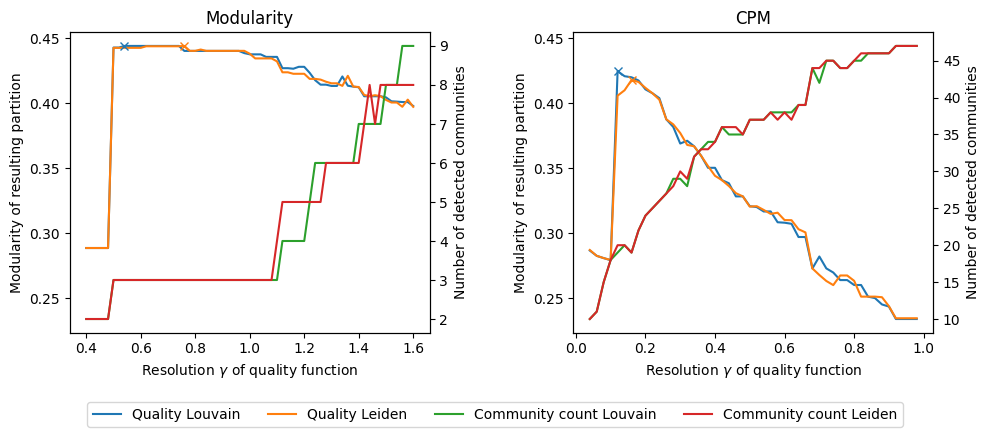

In [8]:
# Set up two graphs, side by side, to plot the results in
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 4), sharey=True)
ax2.yaxis.set_tick_params(labelbottom=True)

## Left graph, for modularity
ax1.set_title("Modularity")
ax1.set_xlabel('Resolution $γ$ of quality function')
ax1.set_ylabel('Modularity of resulting partition')
ax1c = ax1.twinx()
ax1c._get_lines.prop_cycler = ax1._get_lines.prop_cycler
ax1c.set_ylabel('Number of detected communities')

## Right graph, for CPM
ax2.set_title("CPM")
ax2.set_xlabel('Resolution $γ$ of quality function')
ax2.set_ylabel('Modularity of resulting partition')
ax2c = ax2.twinx()
ax2c._get_lines.prop_cycler = ax2._get_lines.prop_cycler
ax2c.set_ylabel('Number of detected communities')

# Draw the results for the modularity quality function
## Plot the modularity determined
ln_mod_louvain_mod, = ax1.plot(resolutions_mod, mod_louvain_mod, label='Quality Louvain')
ln_mod_leiden_mod,  = ax1.plot(resolutions_mod, mod_leiden_mod,  label='Quality Leiden')
## Plot the number of found communities
ln_cnt_louvain_mod, = ax1c.plot(resolutions_mod, list(map(len, coms_louvain_mod)), label='Community count Louvain')
ln_cnt_leiden_mod,  = ax1c.plot(resolutions_mod, list(map(len, coms_leiden_mod)), label='Community count Leiden')

## Draw the x marks where maximum quality is attained
ax1.set_prop_cycle(None)
ax1.plot(resolutions_mod[idx_louvain_mod], mod_louvain_mod[idx_louvain_mod], 'x')
ax1.plot(resolutions_mod[idx_leiden_mod],  mod_leiden_mod[idx_leiden_mod],   'x')

# Draw the results for the CPM quality function
## Plot the modularity determined
ln_mod_louvain_cpm, = ax2.plot(resolutions_cpm, mod_louvain_cpm, label='Louvain CPM')
ln_mod_leiden_cpm,  = ax2.plot(resolutions_cpm, mod_leiden_cpm,  label='Leiden CPM')
## Plot the number of found communities
ln_cnt_louvain_cpm, = ax2c.plot(resolutions_cpm, list(map(len, coms_louvain_cpm)), label='Community count')
ln_cnt_leiden_cpm,  = ax2c.plot(resolutions_cpm, list(map(len, coms_leiden_cpm)), label='Community count')

## Draw the x marks where maximum quality is attained
ax2.set_prop_cycle(None)
ax2.plot(resolutions_cpm[idx_louvain_cpm], mod_louvain_cpm[idx_louvain_cpm], 'x')
ax2.plot(resolutions_cpm[idx_leiden_cpm],  mod_leiden_cpm[idx_leiden_cpm],   'x')

# Put a legend there
lgd = fig.legend(handles=[ln_mod_louvain_mod, ln_mod_leiden_mod, ln_cnt_louvain_mod, ln_cnt_leiden_mod], ncol=4,
                 loc='upper center', bbox_to_anchor=(0.5, 0.0))

# Draw the plot
fig.tight_layout()
fig.subplots_adjust(wspace=0.4)
plt.show()

The scales of the left y-axes are shared for both graphs.

The blue and yellow `x` symbols show where the previously determined modularity-maxima are attained, when using the Louvain and Leiden algorithms, respectively.

In [9]:
# Export the graph, taking care to export the legend as well
fig.savefig('figures/mod-cpm-comparison.pdf', bbox_extra_artists=(lgd,), bbox_inches='tight')

We have also measured the runtime during the calculation, which we're also plotting for comparison:

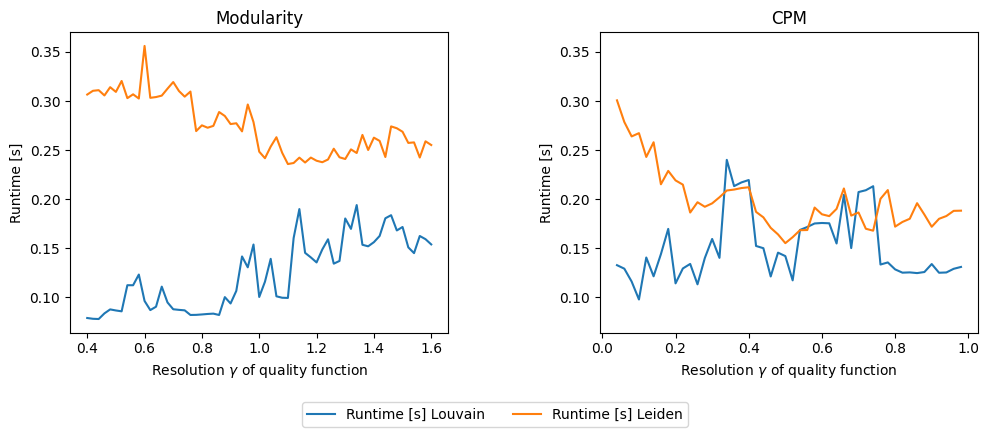

In [10]:
# Set up two graphs, side by side, to plot the results in
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 4), sharey=True)
ax2.yaxis.set_tick_params(labelbottom=True)

## Left graph, for modularity
ax1.set_title("Modularity")
ax1.set_xlabel('Resolution $γ$ of quality function')
ax1.set_ylabel('Runtime [s]')

## Right graph, for CPM
ax2.set_title("CPM")
ax2.set_xlabel('Resolution $γ$ of quality function')
ax2.set_ylabel('Runtime [s]')

# Draw the results for the modularity quality function
## Plot the modularity determined
ln_time_louvain_mod, = ax1.plot(resolutions_mod, times_louvain_mod, label='Runtime [s] Louvain')
ln_time_leiden_mod,  = ax1.plot(resolutions_mod, times_leiden_mod,  label='Runtime [s] Leiden')

# Draw the results for the CPM quality function
## Plot the modularity determined
ln_time_louvain_cpm, = ax2.plot(resolutions_cpm, times_louvain_cpm, label='Runtime [s] Louvain')
ln_time_leiden_cpm,  = ax2.plot(resolutions_cpm, times_leiden_cpm,  label='Runtime [s] Leiden')

# Put a legend there
lgd = fig.legend(handles=[ln_time_louvain_mod, ln_time_leiden_mod,], ncol=2,
                 loc='upper center', bbox_to_anchor=(0.5, 0.0))

# Draw the plot
fig.tight_layout()
fig.subplots_adjust(wspace=0.4)
plt.show()

The plot indicates that (in our implementation) the Leiden algorithm has a longer runtime than the Louvain algorithm.
We observed this with all of our test instances, not only the Jazz musician network.

In general, the runtime differences between the Louvain and the Leiden implementation are more pronunced with Modularity than with the CPM quality function.

Here, the two spikes in the Louvain+CPM graph are notable, at about $γ = 0.35$ and $γ=0.75$.
Those spikes are reproducible and thus likely correspond to the algorithm doing one more iteration than in the other instances (with different $γ$ values).

In [11]:
# Export the graph, taking care to export the legend as well
fig.savefig('figures/mod-cpm-times.pdf', bbox_extra_artists=(lgd,), bbox_inches='tight')